In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
sns.set()

In [2]:
import glob
import os
site_1_X = list(sorted(glob.glob(os.path.join("../Downloads/labeled_train/Nantes_Saint-Nazaire/BDORTHO", "*tif"))))
site_1_Y = list(sorted(glob.glob(os.path.join("../Downloads/labeled_train/Nantes_Saint-Nazaire/UrbanAtlas", "*tif"))))
site_2_X = list(sorted(glob.glob(os.path.join("../Downloads/labeled_train/Nice/BDORTHO", "*tif"))))
site_2_Y = list(sorted(glob.glob(os.path.join("../Downloads/labeled_train/Nice/UrbanAtlas", "*tif"))))

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape, Dropout


def build_FCN(nrows, ncols, nbands, NUMBER_CLASSES):
    """Function to create Keras model of sample network."""
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(7, 7),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
              pool_size=(3, 3),
              strides=(1, 1)
    ))
    model.add(Dropout(0.5))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(Dropout(0.5))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(Dropout(0.5))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(Dropout(0.5))
    model.add(keras.layers.Conv2D(
              filters=NUMBER_CLASSES,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    #model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model

In [4]:
model = build_FCN(320, 320, 3, 15)

2022-01-07 13:57:25.601817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/lib/jvm/java-11-openjdk-amd64/lib/server:/opt/hadoop/lib/native:/usr/local/lib/R/lib:/usr/local/grass78/lib
2022-01-07 13:57:25.603328: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# MAML

In [ ]:
from tqdm import tqdm
from collections import defaultdict

inner_optimizer = tf.keras.optimizers.Adam()
outer_optimizer = tf.keras.optimizers.Adam()
cce = tf.keras.losses.SparseCategoricalCrossentropy()

trained_idx = defaultdict(list)

for i in tqdm(range(20)):

    model_weights = model.get_weights()
    task_weights = []
    query_sets_X, query_sets_Y = [], []
    batch_loss, batch_acc = [], []
    
    for task in range(20):
        site = np.random.choice([0, 1])
        
        if site==0:
            untrained_idx = np.arange(len(site_1_X))[np.logical_not(np.in1d(np.arange(len(site_1_X)), trained_idx[site]))]
            idx = np.random.choice(untrained_idx)
            tiles = rasterio.open(site_1_X[idx]).read()
            tiles = np.swapaxes(tiles, 0, 2)
            tiles = np.swapaxes(tiles, 0, 1)
            tilesY = rasterio.open(site_1_Y[idx]).read()
            tilesY = np.swapaxes(tilesY, 0, 2)
            tilesY = np.swapaxes(tilesY, 0, 1)
        else:
            untrained_idx = np.arange(len(site_2_X))[np.logical_not(np.in1d(np.arange(len(site_2_X)), trained_idx[site]))]
            idx = np.random.choice(untrained_idx)
            tiles = rasterio.open(site_2_X[idx]).read()
            tiles = np.swapaxes(tiles, 0, 2)
            tiles = np.swapaxes(tiles, 0, 1)
            tilesY = rasterio.open(site_2_Y[idx]).read()
            tilesY = np.swapaxes(tilesY, 0, 2)
            tilesY = np.swapaxes(tilesY, 0, 1)
            
        trained_idx[site].append(idx)
        
        #patch = sliding_patches(tiles[i], BSZ=21)
        bh,bw, c = 320, 320, 3
        sz = tiles.itemsize
        h,w = tiles.shape[0], tiles.shape[1]
        shape = (h//bh, w//bw, bh, bw, 3)
        strides = sz*np.array([w*bh,bw,w,1, 1])
        patch=np.lib.stride_tricks.as_strided(tiles, shape=shape, strides=strides).reshape(-1, 320, 320, 3)
        
        # Generate Support Set X
        support_idx = np.random.choice(range(patch.shape[0]), size=3*patch.shape[0]//4)
        support_set_X = patch[support_idx]
        
        # Generate Query Set X
        query_set_X = patch[np.delete(range(patch.shape[0]), support_idx)]
        query_sets_X.append(query_set_X)
        
        bh,bw, c = 320, 320, 1
        sz = tilesY.itemsize
        h,w = tilesY.shape[0], tilesY.shape[1]
        shape = (h//bh, w//bw, bh, bw, 1)
        strides = sz*np.array([w*bh,bw,w,1, 1])
        patch=np.lib.stride_tricks.as_strided(tilesY, shape=shape, strides=strides).reshape(-1, 320, 320, 1)
        
        # Generate Support Set Y
        support_set_Y = patch[support_idx]
        support_set_Y = support_set_Y.astype(np.uint8)
        
        # Generate Query Set Y
        query_set_Y = patch[np.delete(range(patch.shape[0]), support_idx)]
        query_set_Y = query_set_Y.astype(np.uint8)
        query_sets_Y.append(query_set_Y)
    
        # Meta Train
        model.set_weights(model_weights)
        for epoch in range(20):
            for batch in range(0, support_set_X.shape[0], 5):
                with tf.GradientTape() as train_tape:
                    train_loss = cce(support_set_Y[batch:batch+5], model(support_set_X[batch:batch+5]))
                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                inner_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        task_weights.append(model.get_weights())
        
    # Meta Update
    with tf.GradientTape() as test_tape:
        for m in range(20):
            model.set_weights(task_weights[m])
            for batch in range(0, query_sets_Y[m].shape[0], 5):
                test_loss = cce(query_sets_Y[m][batch:batch+5], model(query_sets_X[m][batch:batch+5]))
                batch_loss.append(test_loss)
                acc = tf.cast(tf.argmax(model(query_sets_X[m][batch:batch+5]), axis=3) == np.squeeze(query_sets_Y[m][batch:batch+5], axis=3), tf.float32)
                acc = tf.reduce_mean(acc)
                batch_acc.append(acc)
                #print(acc)
        mean_acc = tf.reduce_mean(batch_acc)
        mean_loss = tf.reduce_mean(batch_loss)
        print(mean_acc)
    model.set_weights(model_weights)
    gradients = test_tape.gradient(mean_loss, model.trainable_variables)
    outer_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    model.save(F"./models/model_{i}")
    np.save(F"trained_idx_{i}", trained_idx)

  0%|          | 0/50 [00:00<?, ?it/s]

tf.Tensor(0.7051754, shape=(), dtype=float32)


2022-01-07 14:02:24.770446: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/model_0/assets


  2%|▏         | 1/50 [04:52<3:58:43, 292.32s/it]

tf.Tensor(0.6255498, shape=(), dtype=float32)
INFO:tensorflow:Assets written to: ./models/model_1/assets


  4%|▍         | 2/50 [08:59<3:32:35, 265.73s/it]

tf.Tensor(0.66332656, shape=(), dtype=float32)
INFO:tensorflow:Assets written to: ./models/model_2/assets


  6%|▌         | 3/50 [12:51<3:16:08, 250.40s/it]

tf.Tensor(0.5975603, shape=(), dtype=float32)
INFO:tensorflow:Assets written to: ./models/model_3/assets


  8%|▊         | 4/50 [16:45<3:06:57, 243.86s/it]

tf.Tensor(0.37701213, shape=(), dtype=float32)
INFO:tensorflow:Assets written to: ./models/model_4/assets


 10%|█         | 5/50 [20:45<3:01:54, 242.55s/it]

tf.Tensor(0.48586506, shape=(), dtype=float32)
INFO:tensorflow:Assets written to: ./models/model_5/assets


 12%|█▏        | 6/50 [24:39<2:55:45, 239.68s/it]

tf.Tensor(0.4812325, shape=(), dtype=float32)
INFO:tensorflow:Assets written to: ./models/model_6/assets


 14%|█▍        | 7/50 [28:37<2:51:12, 238.90s/it]

tf.Tensor(0.4006958, shape=(), dtype=float32)
INFO:tensorflow:Assets written to: ./models/model_7/assets


 16%|█▌        | 8/50 [32:40<2:48:14, 240.35s/it]

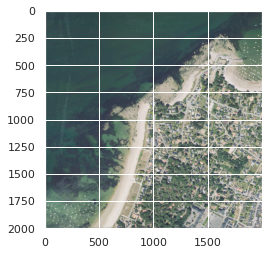

In [107]:
plt.imshow(tiles[10])

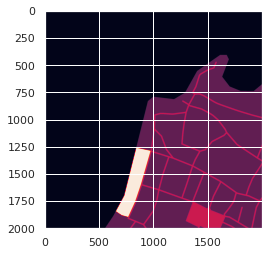

In [108]:
plt.imshow(tilesY[10])